# Sentence-BERT data augmentation

In [3]:
from pathlib import Path

data_dir = Path(".")
assert data_dir.exists()

In [10]:
import pandas as pd

# Load df dataset
df_train = pd.read_feather(data_dir / "stsbenchmark" / "sts-train.feather")
df_val = pd.read_feather(data_dir / "stsbenchmark" / "sts-dev.feather")
df = pd.concat([df_train, df_val]).reset_index(drop=True)

## Compute Embeddings
Use Sentence-BERT to compute sentence embeddings

In [12]:
import torch
from sentence_transformers import SentenceTransformer

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"using device: {device}")

# load sbert model
model = SentenceTransformer("stsb-mpnet-base-v2")

using device: cuda:0


In [13]:
# compute sentence embeddings with sbert
s1_embeds = model.encode(df.s1, convert_to_tensor=True, device=device)
s2_embeds = model.encode(df.s2, convert_to_tensor=True, device=device)

In [14]:
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# compute similarity scores via cosine similarity
s1_embeds = F.normalize(s1_embeds)
s2_embeds = F.normalize(s2_embeds)
sbert_scores = (s1_embeds.unsqueeze(1) @ s2_embeds.unsqueeze(2)).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
sbert_scores = MinMaxScaler().fit_transform(sbert_scores).squeeze()

SpearmanRank: 0.9544


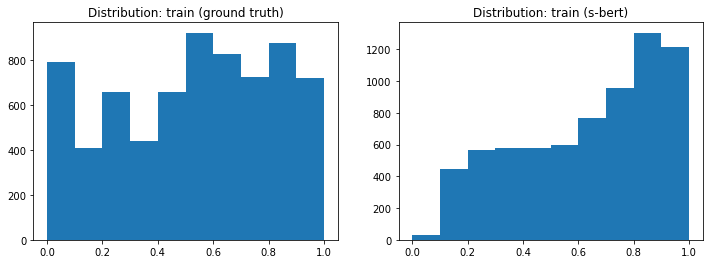

In [15]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

spearman = spearmanr(sbert_scores, df.score)[0]
print(f"SpearmanRank: {spearman:.4f}")

# plot distributions
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df.score, bins=10)
ax[0].set_title("Distribution: train (ground truth)")
ax[1].hist(sbert_scores, bins=10)
ax[1].set_title("Distribution: train (s-bert)")
plt.show()

In [16]:
# save benchmark dataset with sbert scores
df_sbert = pd.DataFrame({
    "idx1": list(range(len(df.s1))),
    "idx2": list(range(len(df.s2))),
    "score": sbert_scores,
})
df_sbert.to_feather(data_dir / "df_sbert.feather")

## Create augmentation data
Create new sentence pairs and score them via cosine similarity

In [17]:
import numpy as np

# get the index of the unique sentences
s1_unique_idxs = df.s1.drop_duplicates().index.values
s2_unique_idxs = df.s2.drop_duplicates().index.values
# create array that holds all possible index pair combinations
index_pairs = np.stack(np.meshgrid(s1_unique_idxs, s2_unique_idxs), axis=-1).reshape(-1, 2)
print(f"#sentence-pairs: {index_pairs.shape[0]}")

#sentence-pairs: 43507020


In [18]:
from tqdm.notebook import tqdm

# compute scores via cosine similarity
# batching needed due to the insane number of sentence pairs
dataloader = torch.utils.data.DataLoader(index_pairs, batch_size=8192)
scores = torch.cat([
    s1_embeds[idxs[:, 0]].unsqueeze(1) @ s2_embeds[idxs[:, 1]].unsqueeze(2)
    for idxs in tqdm(dataloader)
]).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
scores = MinMaxScaler().fit_transform(scores).squeeze()

  0%|          | 0/5311 [00:00<?, ?it/s]

In [19]:
df_augment = pd.DataFrame({
    "idx1": index_pairs[..., 0],
    "idx2": index_pairs[..., 1],
    "score": scores
})

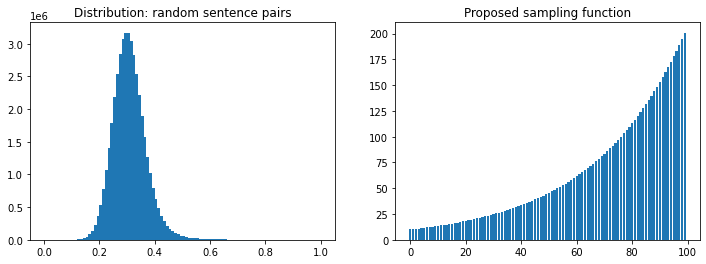

In [20]:
N_BINS = 100
SEED = 1337
np.random.seed(1337)
f = lambda x: np.exp(3*x) * 10  # sampling function
X = np.linspace(0, 1, N_BINS)


# plot distribution and sampling function
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df_augment.score, bins=100)
ax[0].set_title("Distribution: random sentence pairs")
ax[1].bar(range(N_BINS), f(X))
ax[1].set_title("Proposed sampling function")
plt.show()

In [21]:
# create bins
bins = np.histogram_bin_edges(df_augment.score, bins=N_BINS)
indices = np.digitize(df_augment.score, bins)

In [22]:
# sampling from bins
sample_idxs = []
for i, x in enumerate(tqdm(X)):
    bin_indices = np.where(indices == i)[0]
    if len(bin_indices) > 1:
        n = int(f(x))
        if len(bin_indices) < n:
            sample_idxs.append(bin_indices)
        else:
            sample_idxs.append(np.random.choice(bin_indices, size=n, replace=False))
# concatenate sampled bins together
sample_idxs = np.concatenate(sample_idxs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
# create dataframe of sampled examples and save it to disk
df_augment_sampled = df_augment.iloc[sample_idxs].reset_index()
df_augment_sampled.to_feather(data_dir / "df_augment.feather")
print(f"{len(df_augment_sampled)} examples sampled")

6307 examples sampled


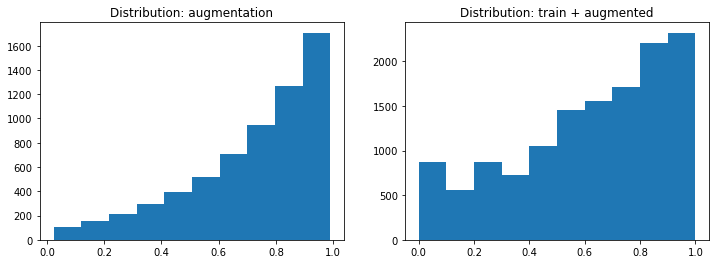

In [24]:
# plot distributions
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df_augment_sampled.score, bins=10)
ax[0].set_title("Distribution: augmentation")
ax[1].hist(np.concatenate([df_augment_sampled.score, df.score]), bins=10)
ax[1].set_title("Distribution: train + augmented")
plt.show()